
# Predict Local Spatial Frequency with a TensorFlow/Keras Model (Multi‑Output)

This notebook reproduces **Copy_of_testMultipleResponsesPredictUsingML.asv** but using a
**TensorFlow/Keras** multi-output regression model. It reads the model paths from an Excel DB row,
builds features on sliding patches, calculates features and predicts `[w, φx, φy, θ]` maps, and draws quick diagnostics.

68 LENSPMD25 INFORME-OM4M007 medida spatial freqs using ML

**Conda enviroment:**

run conda activate LENSPMD25-base310 

if not present create enviroment using yml file



In [1]:
# ---
# ✅ Colab bootstrap for LensPMD
# How to open in Colab:
# 1) Clone the LensPMD repo into Google Drive.
# 2) In Drive (web), right-click the notebook → “Open with” → “Google Colab”.
# 3) Run this cell to mount Drive, set the working directory, and verify required paths.
# ---

import os
from pathlib import Path

# === Detect Colab =============================================================
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print(f"Running in Colab? {IN_COLAB}")

# === Setup when in Colab ======================================================
if IN_COLAB:
    from google.colab import drive  # type: ignore
    DRIVE_MOUNT_POINT = "/content/drive"
    PROJECT_REL_PATH = "MyDrive/Colab Notebooks/68_LensPMD25_INFORME-OM4M007/Python_src"
    REQUIRED_PATH = "/content/drive/MyDrive/Colab Notebooks/68_LensPMD25_INFORME-OM4M007/local_data"

    # Mount Google Drive
    drive.mount(DRIVE_MOUNT_POINT, force_remount=True)

    # Set working directory
    project_path = Path(DRIVE_MOUNT_POINT) / PROJECT_REL_PATH
    if not project_path.exists():
        raise FileNotFoundError(f"❌ Project directory not found: {project_path}")

    os.chdir(project_path)
    print("✅ Working Directory:", Path.cwd())

    # Verify required local_data folder exists
    local_data_path = Path(REQUIRED_PATH)
    if not local_data_path.exists():
        raise FileNotFoundError(
            f"❌ Required directory not found: {local_data_path}\n"
            "Please ensure 'local_data' exists in the LensPMD folder in your Drive."
        )

    print("✅ Required folder found:", local_data_path)
    print("📂 Files in Working Directory:", os.listdir())

else:
    print("Not running in Colab — skipping Drive mount and WD setup.")
    print("Current Working Directory:", Path.cwd())


Running in Colab? False
Not running in Colab — skipping Drive mount and WD setup.
Current Working Directory: c:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\Python_src


In [2]:

# --- Setup ---
# %pip install tensorflow==2.16.* scikit-learn==1.4.* pandas openpyxl matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import tensorflow as tf
from ml_spatialfreq_utils import (
    TrainedModelTF, DBInfo, calc_spatial_freqs_supervised_regression_batch, synth_fringe, peaks
)

from ml_spatialfreq_utils_v2 import calc_spatial_freqs_supervised_regression_batch_gpu



plt.rcParams["figure.figsize"] = (5.5, 4.2)


In [3]:
# Check for GPUs

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    try:
        for d in tf.config.list_physical_devices('GPU'):
            tf.config.experimental.set_memory_growth(d, True)
    except Exception as e:
        print("Could not set memory growth:", e)

TensorFlow version: 2.16.2
Built with CUDA: False
GPU devices: []


In [4]:

# --- Resolve model paths from the DB Excel ---
rootFolderDB = Path('../local_data/ML_Models')              # Adjust if needed
db_name = 'DB-trainingSets-OM4M007.xlsx'        # Same as MATLAB
db_sheet = 'Sheet1'                             
trainingSet_Idx = 12                              # 1-based row index

db_path = rootFolderDB / db_name
print("Reading DB:", db_path.resolve())
db_tb = pd.read_excel(db_path, sheet_name=db_sheet)

row_idx = trainingSet_Idx - 1
assert 0 <= row_idx < len(db_tb), "trainingSet_Idx out of range"

row = db_tb.iloc[row_idx].to_dict()

# Expected columns for Python artifacts (preferred). If missing, you can fill them below.
kerasModelPath = rootFolderDB / row.get('trainedModel')
scalerPath     = rootFolderDB / row.get('scaler')
featureMetadataPath  = rootFolderDB / row.get('feature_metadata')
featureName    = row.get('featureName')
patch_NR       = int(row.get('patch_NR'))
patch_NC       = int(row.get('patch_NC'))

print("kerasModel Name:", kerasModelPath)
print("scaler name    :", scalerPath)
print("feature_metadata name      :", featureMetadataPath)
print("feature Name   :", featureName, " patch:", patch_NR, "x", patch_NC)


Reading DB: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\DB-trainingSets-OM4M007.xlsx
kerasModel Name: ..\local_data\ML_Models\trainedModel_07-10-2025_DB_feature_projected_DFT_13x13_GVN-0_NS-15000_28-Aug-2025.keras
scaler name    : ..\local_data\ML_Models\scaler_07-10-2025_DB_feature_projected_DFT_13x13_GVN-0_NS-15000_28-Aug-2025.pkl
feature_metadata name      : ..\local_data\ML_Models\feature_metadata_07-10-2025_DB_feature_projected_DFT_13x13_GVN-0_NS-15000_28-Aug-2025.json
feature Name   : feature_projected_DFT  patch: 13 x 13


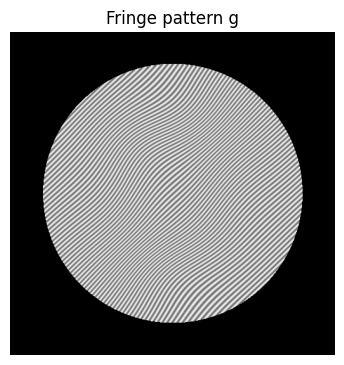

In [5]:

# --- Build or load a test fringe pattern (like the MATLAB script) ---
NR, NC = 511, 512
y, x = np.mgrid[0:NR, 0:NC]
y=y-0.5*NR; x=x-0.5*NC
R=0.4*NR

# M_ROI = np.ones_like(g, dtype=bool)  # full image ROI
M_ROI = np.abs(x + 1j*y)<R

w0_x, w0_y = np.pi/4, np.pi/4
psi = 3*peaks(NR, NC)
g, w_phi, phi_x, phi_y, theta = synth_fringe(NR, NC, w0_x, w0_y, psi, modulation=50, background=128, noise_std=2, return_maps=True)

plt.figure(); plt.imshow(g*M_ROI, cmap='gray'); plt.title('Fringe pattern g'); plt.axis('off'); plt.show()



In [6]:

# --- Predict spatial-frequency maps ---
dbi = DBInfo(featureName=str(featureName), patch_NR=int(patch_NR), patch_NC=int(patch_NC))
tm = TrainedModelTF(model_path=kerasModelPath, scaler_path=scalerPath, meta_path=featureMetadataPath, DB_info=dbi)

w_phi_pred, phi_x_pred, phi_y_pred, theta_pred, QM, M_proc, t = calc_spatial_freqs_supervised_regression_batch(
    g, tm, feature_name=str(featureName), M_ROI=M_ROI, return_timing=True
)

print("=== Timing (seconds) ===")
print(f"Load Model: {t['model_load']:.4f}")
print(f"feature: {t['feature']:.4f}")
print(f"predict: {t['predict']:.4f}")
print(f"total : {t['total']:.4f}")


=== Timing (seconds) ===
Load Model: 0.0984
feature: 1.6175
predict: 2.0898
total : 3.8058


In [7]:
# GPU optimized version

w_phi_pred, phi_x_pred, phi_y_pred, theta_pred, QM, M_proc, t = calc_spatial_freqs_supervised_regression_batch_gpu(
    g, tm, feature_name=str(featureName), M_ROI=M_ROI, return_timing=True
)

print(f"GPU  patch : {t['patch']:.4f}")
print(f"GPU  feat  : {t['feature']:.4f}")
print(f"GPU  predict: {t['predict']:.4f}")
print(f"GPU  total : {t['total']:.4f}")

False
GPU  patch : 0.0000
GPU  feat  : 1.9958
GPU  predict: 0.0454
GPU  total : 2.0411


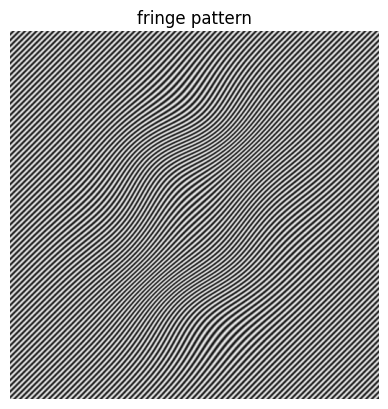

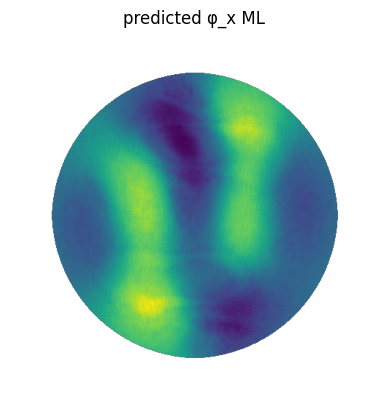

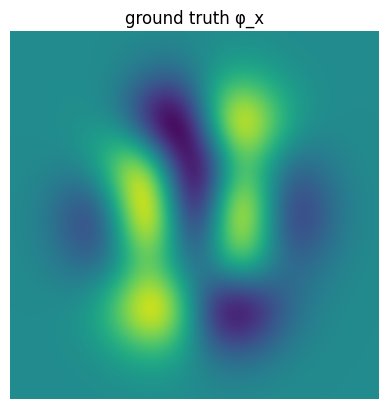

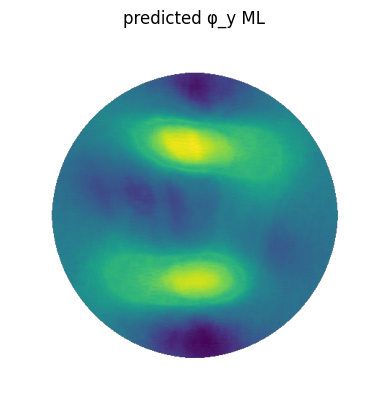

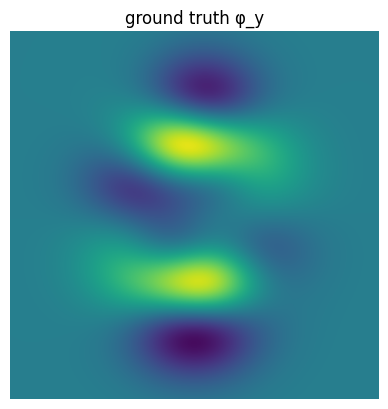

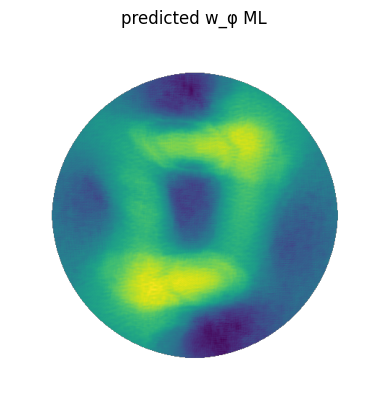

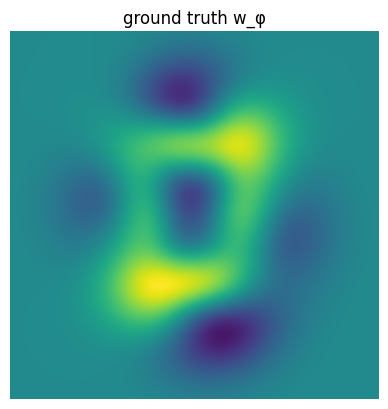

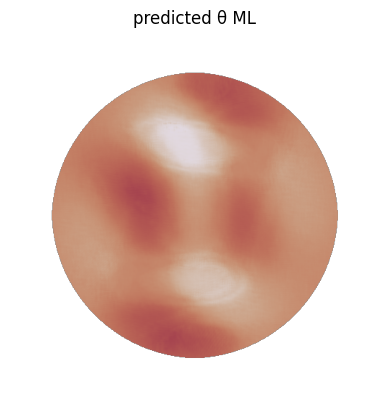

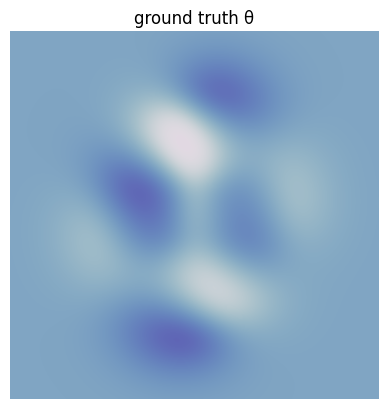

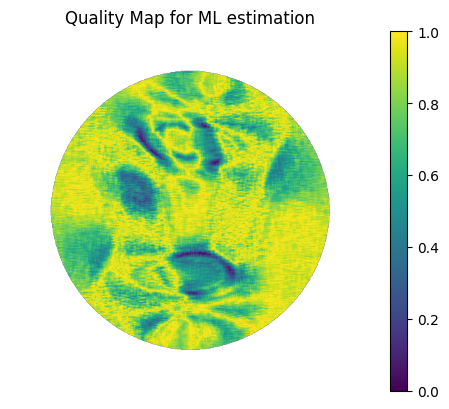

In [8]:

# Display predictions (where valid)

# Build MNan so invalid pixels show as NaN (transparent in imshow with default settings)
MNan = M_proc.astype(float)
MNan[MNan == 0] = np.nan

# Helper: consistent limits for a pair (pred, gt)
def pair_clim(pred, gt, mask):
    a = np.nanmin([np.nanmin(pred*mask), np.nanmin(gt)]) if np.isfinite(gt).any() else np.nanmin(pred*mask)
    b = np.nanmax([np.nanmax(pred*mask), np.nanmax(gt)]) if np.isfinite(gt).any() else np.nanmax(pred*mask)
    if not np.isfinite(a): a = 0.0
    if not np.isfinite(b) or b == a: b = a + 1e-6
    return (a, b)

# 1) Fringe pattern (grayscale)
plt.figure(num='fringe pattern')
plt.imshow(g, cmap='gray')
plt.title('fringe pattern')
plt.axis('off')
plt.tight_layout()

# 2) φ_x (pred vs GT)
vmin, vmax = pair_clim(phi_x_pred, phi_x, MNan)
plt.figure(num='pred φ_x')
plt.imshow(phi_x_pred * MNan, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('predicted φ_x ML')
plt.axis('off')
plt.tight_layout()

plt.figure(num='φ_x (GT)')
plt.imshow(phi_x, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('ground truth φ_x')
plt.axis('off')
plt.tight_layout()

# 3) φ_y (pred vs GT)
vmin, vmax = pair_clim(phi_y_pred, phi_y, MNan)
plt.figure(num='pred φ_y')
plt.imshow(phi_y_pred * MNan, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('predicted φ_y ML')
plt.axis('off')
plt.tight_layout()

plt.figure(num='φ_y (GT)')
plt.imshow(phi_y, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('ground truth φ_y')
plt.axis('off')
plt.tight_layout()

# 4) w_φ (pred vs GT)
vmin, vmax = pair_clim(w_phi_pred, w_phi, MNan)
plt.figure(num='pred w_φ')
plt.imshow(w_phi_pred * MNan, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('predicted w_φ ML')
plt.axis('off')
plt.tight_layout()

plt.figure(num='w_φ (GT)')
plt.imshow(w_phi, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('ground truth w_φ')
plt.axis('off')
plt.tight_layout()

# 5) θ (pred vs GT)  — orientation; twilight is nice for angles
vmin, vmax = pair_clim(theta_pred, theta, MNan)
plt.figure(num='pred θ')
plt.imshow(theta_pred * MNan, cmap='twilight', vmin=vmin, vmax=vmax)
plt.title('predicted θ ML')
plt.axis('off')
plt.tight_layout()

plt.figure(num='θ (GT)')
plt.imshow(theta, cmap='twilight', vmin=vmin, vmax=vmax)
plt.title('ground truth θ')
plt.axis('off')
plt.tight_layout()

# 6) Quality Map
plt.figure(num='QM')
im = plt.imshow(QM.astype(float))
plt.title('Quality Map for ML estimation')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis('off')
plt.tight_layout()

plt.show()


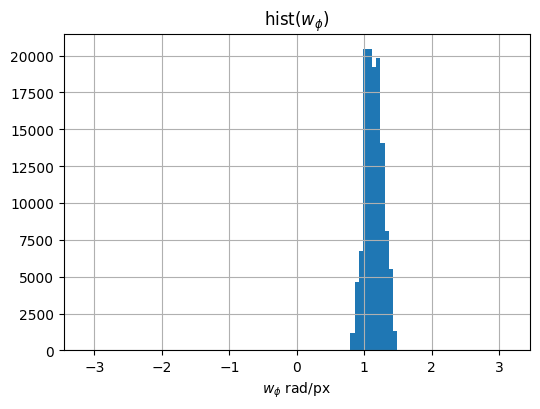

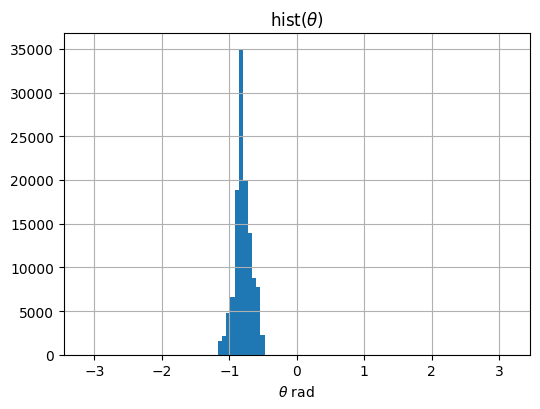

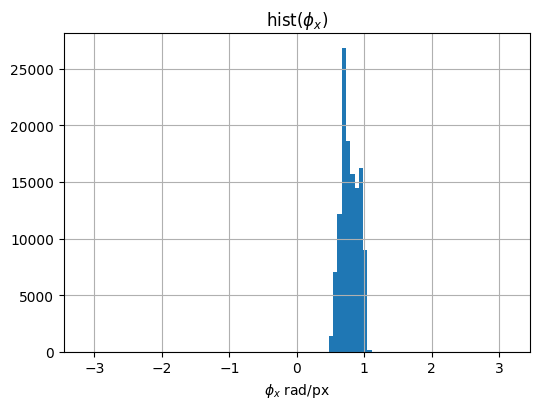

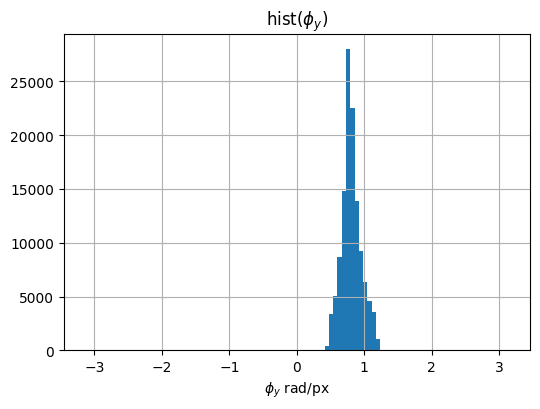

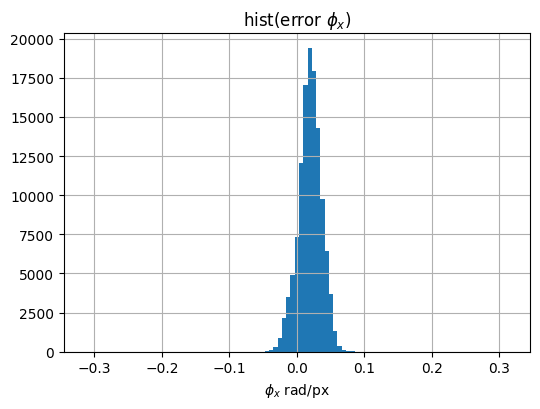

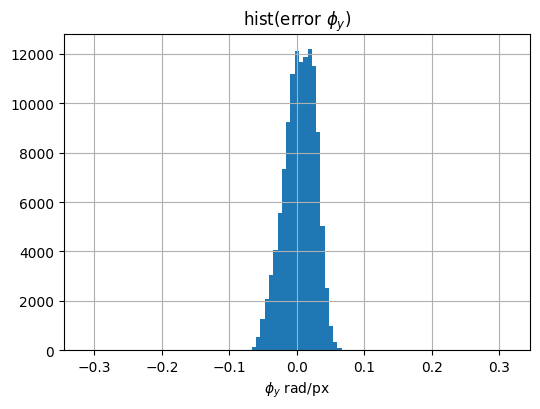

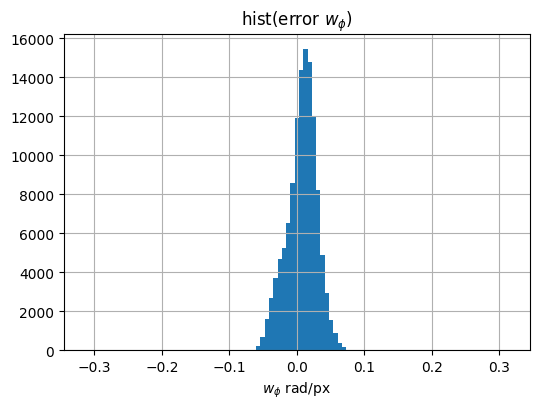

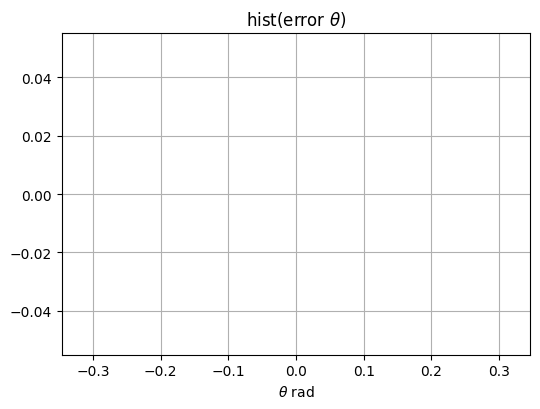

In [9]:

# --- Histograms on valid pixels (as in MATLAB) ---
"""
mask = QM
edges1 = np.linspace(-np.pi, np.pi, 100)

plt.figure(); plt.hist(w_phi_pred[mask], bins=edges1); plt.title('hist(w_φ)'); plt.xlabel('rad/px'); plt.show()
plt.figure(); plt.hist(theta_pred[mask], bins=edges1); plt.title('hist(θ)');   plt.xlabel('rad');    plt.show()
plt.figure(); plt.hist(phi_x_pred[mask], bins=edges1); plt.title('hist(φ_x)'); plt.xlabel('rad/px'); plt.show()
plt.figure(); plt.hist(phi_y_pred[mask], bins=edges1); plt.title('hist(φ_y)'); plt.xlabel('rad/px'); plt.show()
"""
# Logical mask like MATLAB's M_proc (nonzero -> True)
mask = M_proc.astype(bool)

# Bin edges
histEdge1 = np.linspace(-np.pi,     np.pi,     100)
histEdge2 = np.linspace(-np.pi / 10, np.pi / 10, 100)

# ---- Ground-truth histograms (masked by M_proc) ----
plt.figure(); plt.hist(w_phi[mask], bins=histEdge1)
plt.title(r'hist($w_\phi$)'); plt.xlabel(r'$w_\phi$ rad/px'); plt.grid(True); plt.tight_layout()

plt.figure(); plt.hist(theta[mask], bins=histEdge1)
plt.title(r'hist($\theta$)'); plt.xlabel(r'$\theta$ rad'); plt.grid(True); plt.tight_layout()

plt.figure(); plt.hist(phi_x[mask], bins=histEdge1)
plt.title(r'hist($\phi_x$)'); plt.xlabel(r'$\phi_x$ rad/px'); plt.grid(True); plt.tight_layout()

plt.figure(); plt.hist(phi_y[mask], bins=histEdge1)
plt.title(r'hist($\phi_y$)'); plt.xlabel(r'$\phi_y$ rad/px'); plt.grid(True); plt.tight_layout()

# ---- Error histograms: (GT - Pred) over the same mask ----
err_phi_x = (phi_x - phi_x_pred)[mask]
err_phi_y = (phi_y - phi_y_pred)[mask]
err_w_phi = (w_phi - w_phi_pred)[mask]
err_theta = (theta - theta_pred)[mask]
# Optional: wrap angular error to [-pi, pi]
# err_theta = np.angle(np.exp(1j*err_theta))

plt.figure(); plt.hist(err_phi_x, bins=histEdge2)
plt.title(r'hist(error $\phi_x$)'); plt.xlabel(r'$\phi_x$ rad/px'); plt.grid(True); plt.tight_layout()

plt.figure(); plt.hist(err_phi_y, bins=histEdge2)
plt.title(r'hist(error $\phi_y$)'); plt.xlabel(r'$\phi_y$ rad/px'); plt.grid(True); plt.tight_layout()

plt.figure(); plt.hist(err_w_phi, bins=histEdge2)
plt.title(r'hist(error $w_\phi$)'); plt.xlabel(r'$w_\phi$ rad/px'); plt.grid(True); plt.tight_layout()

plt.figure(); plt.hist(err_theta, bins=histEdge2)
plt.title(r'hist(error $\theta$)'); plt.xlabel(r'$\theta$ rad'); plt.grid(True); plt.tight_layout()

plt.show()

